In [16]:
import librosa
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import seaborn as sns
import warnings
from glob import glob
import pandas as pd
import pickle

In [17]:
langs = ["Hindi", "Kannada", "Tamil", "Telugu","Urdu","Malayalam", "Bengali", "Marathi", "Punjabi", "Gujarati"]
mfccs_feature = []
classes = []
for lang in langs:
    file_name = f"{lang}_features.pkl"
    # print(f"Shape of {file_name}: {np.array(features['features']).shape}")
    try:
        with open(file_name, "rb") as f:
            if file_name == "Punjabi_features.pkl":
                features = pickle.load(f)
                mfccs_feature += features[:5000]
                classes += ([lang] * len(features[:5000]))
            else:
                features = pickle.load(f)
                mfccs_feature+=features["features"][:5000]
                tot_lang=[lang]*len(features["features"][:5000])
                classes+=tot_lang
    except FileNotFoundError:
        print(f"File {file_name} not found.")

df = pd.DataFrame({'MFCC_Features': mfccs_feature, 'Class': classes})

In [3]:
# with open('Hindi_features.pkl', 'rb') as f:
#     hindi_features = pickle.load(f)
#     print(f"Shape of Hindi features: {np.array(hindi_features['features']).shape}")
# with open('Kannada_features.pkl', 'rb') as f:
#     kannada_features = pickle.load(f)
#     print(f"Shape of Kannada features: {np.array(kannada_features['features']).shape}")
# with open('Tamil_features.pkl', 'rb') as f:
#     tamil_features = pickle.load(f)
#     print(f"Shape of Tamil features: {np.array(tamil_features['features']).shape}")
# with open('Telugu_features.pkl', 'rb') as f:
#     telugu_features = pickle.load(f)
#     print(f"Shape of Telugu features: {np.array(telugu_features['features']).shape}")
# with open('Urdu_features.pkl', 'rb') as f:
#     urdu_features = pickle.load(f)
#     print(f"Shape of Urdu features: {np.array(urdu_features['features']).shape}")
# with open('Malayalam_features.pkl', 'rb') as f:
#     malayalam_features = pickle.load(f)
#     print(f"Shape of Malayalam features: {np.array(malayalam_features['features']).shape}")
# with open('Bengali_features.pkl', 'rb') as f:
#     bengali_features = pickle.load(f)
#     print(f"Shape of Bengali features: {np.array(bengali_features['features']).shape}")
# with open('Marathi_features.pkl', 'rb') as f:
#     marathi_features = pickle.load(f)
#     print(f"Shape of Marathi features: {np.array(marathi_features['features']).shape}")
# with open('Punjabi_features.pkl', 'rb') as f:
#     punjabi_features = pickle.load(f)
#     print(f"Shape of Punjabi features: {len(punjabi_features)}")


In [32]:
# df = pd.DataFrame({'MFCC_Features': mfccs_feature, 'Class': classes})
# df.shape
# print(df['Class'].unique())

# df = df[df['Class'] != 'Punjabi']
print(df.shape)
df['Class'].value_counts()

(49697, 2)


Class
Telugu       5000
Malayalam    4999
Marathi      4993
Bengali      4992
Tamil        4983
Gujarati     4982
Urdu         4971
Kannada      4955
Hindi        4953
Punjabi      4869
Name: count, dtype: int64

In [33]:
new_df = df.sample(49697, random_state=42)
print(df['Class'].unique())

new_df.head()

['Hindi' 'Kannada' 'Tamil' 'Telugu' 'Urdu' 'Malayalam' 'Bengali' 'Marathi'
 'Punjabi' 'Gujarati']


,MFCC_Features,Class
11902,"[-263.7336, 189.09041, 1.627193, 8.388803, 15....",Tamil
4162,"[-334.05466, 131.65575, -9.602661, 61.670795, ...",Hindi
17736,"[-376.4621, 151.25067, -28.79984, 3.2704184, 2...",Telugu
46682,"[-367.99207, 135.57188, 7.8631797, -6.456845, ...",Gujarati
38825,"[-283.68475, 118.693054, 4.528077, 22.387888, ...",Marathi


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import math
from torch import Tensor
import torch
from einops import rearrange
import torch.nn.functional as F
from einops.layers.torch import Rearrange,Reduce

In [35]:
lbl = LabelEncoder()
y = lbl.fit_transform(new_df['Class'])
X = np.array(new_df['MFCC_Features'].tolist())
y = np.array(y.tolist())

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

In [36]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, expansion, dropout=0.1):
        super(TransformerEncoderBlock, self).__init__()
        
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout)

        self.ff = nn.Sequential(
            nn.Linear(embed_dim, expansion * embed_dim),
            nn.ReLU(),
            nn.Linear(expansion*embed_dim, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, src_mask=None, src_key_padding_mask=None):
        attn_output, _ = self.attention(x, x, x, attn_mask=src_mask,
                                        key_padding_mask=src_key_padding_mask)
        x = x + self.dropout1(attn_output)
        x = self.norm1(x)
        ff_output = self.ff(x)
        x = x + self.dropout2(ff_output)
        x = self.norm2(x)

        return x

In [37]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size, n_classes):
        super().__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(emb_size, 256),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(256, 32),
            nn.ELU(),
            nn.Dropout(0.3),
            nn.Linear(32, n_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        out = self.fc(x)
        return out

In [38]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth, emb_size):
        super().__init__(*[TransformerEncoderBlock(emb_size,num_heads=5,expansion=4) for _ in range(depth)])
class Classifier(nn.Sequential):
    def __init__(self, emb_size=40, depth=3, **kwargs):
        super().__init__(
            TransformerEncoder(depth, emb_size),
            ClassificationHead(emb_size, 10)
        )
        

In [44]:
# Ensure the model is on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
model = Classifier().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Convert data to PyTorch tensors and move to GPU
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

# Training loop
epochs = 100
batch_size = 16
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for i in range(0, len(X_train_tensor), batch_size):
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(X_train_tensor):.4f}")
    torch.save(model.state_dict(), "LOOOONG_TRAIN.pth")

Epoch 1/100, Loss: 0.1336
Epoch 2/100, Loss: 0.1227
Epoch 3/100, Loss: 0.1186
Epoch 4/100, Loss: 0.1165
Epoch 5/100, Loss: 0.1150
Epoch 6/100, Loss: 0.1141
Epoch 7/100, Loss: 0.1132
Epoch 8/100, Loss: 0.1125
Epoch 9/100, Loss: 0.1120
Epoch 10/100, Loss: 0.1114
Epoch 11/100, Loss: 0.1105
Epoch 12/100, Loss: 0.1098
Epoch 13/100, Loss: 0.1092
Epoch 14/100, Loss: 0.1085
Epoch 15/100, Loss: 0.1081
Epoch 16/100, Loss: 0.1077
Epoch 17/100, Loss: 0.1072
Epoch 18/100, Loss: 0.1068
Epoch 19/100, Loss: 0.1063
Epoch 20/100, Loss: 0.1060
Epoch 21/100, Loss: 0.1056
Epoch 22/100, Loss: 0.1054
Epoch 23/100, Loss: 0.1051
Epoch 24/100, Loss: 0.1047
Epoch 25/100, Loss: 0.1044
Epoch 26/100, Loss: 0.1043
Epoch 27/100, Loss: 0.1041
Epoch 28/100, Loss: 0.1039
Epoch 29/100, Loss: 0.1036
Epoch 30/100, Loss: 0.1033
Epoch 31/100, Loss: 0.1033
Epoch 32/100, Loss: 0.1030
Epoch 33/100, Loss: 0.1028
Epoch 34/100, Loss: 0.1026
Epoch 35/100, Loss: 0.1025
Epoch 36/100, Loss: 0.1024
Epoch 37/100, Loss: 0.1021
Epoch 38/1

In [45]:
torch.save(model.state_dict(), "LOOOONG_TRAIN.pth")

In [46]:
print(y_train.shape)

(39757,)


In [47]:
# Convert test data to PyTorch tensors and move to GPU
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Set the model to evaluation mode
model.eval()

# Get predictions
with torch.no_grad():
    outputs = model(X_test_tensor)
    y_pred = torch.argmax(outputs, dim=1).cpu().numpy()

# Evaluate the model
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8719


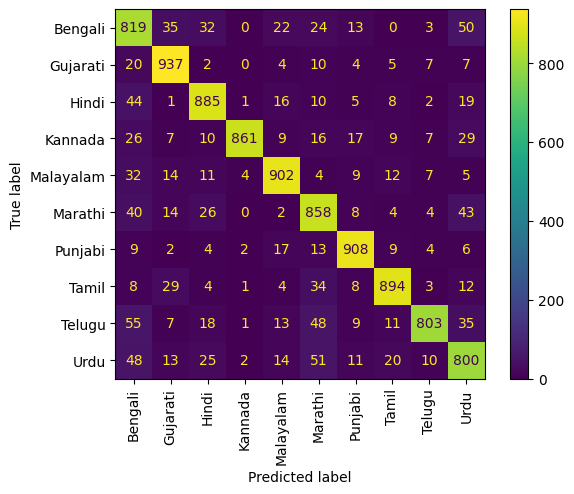

In [48]:
cnf = confusion_matrix(y_test,y_pred)
ConfusionMatrixDisplay(cnf,display_labels=lbl.classes_).plot()
plt.xticks(rotation=90)
plt.show()

In [66]:
def normalize_amplitude(y):
    """Normalize audio signal to -1 to 1 range."""
    return y / np.max(np.abs(y))

def fast_pitch_normalize(y, sr, target_pitch_hz=150.0):
    # Estimate pitch using YIN
    f0 = librosa.yin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    mean_pitch = np.mean(f0)

    # Calculate semitone shift
    n_steps = librosa.hz_to_midi(target_pitch_hz) - librosa.hz_to_midi(mean_pitch)

    # Apply pitch shift
    y_shifted = librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)
    return y_shifted

def feature_extractor(file):
    audio_data,sample_rate = librosa.load(file)
    audio_data = normalize_amplitude(audio_data)
    audio_data = fast_pitch_normalize(audio_data, sample_rate)
    mfcc_feature = librosa.feature.mfcc(y=audio_data,sr=sample_rate,n_mfcc=40)
    scaled_feature = np.mean(mfcc_feature.T,axis=0)
    return scaled_feature

mfccs_feature_custom = []
classes_custom = []
file = "hindi_akshat.mp3"
mfccs_feature_custom.append(feature_extractor(file))
classes_custom.append("Bengali")


print("done")

done


In [67]:
# Convert mfccs_feature_custom to a PyTorch tensor and move to the appropriate device
if mfccs_feature_custom:
    custom_features_tensor = torch.tensor(mfccs_feature_custom, dtype=torch.float32).to(device)

    # Forward pass through the model
    model.eval()
    with torch.no_grad():
        custom_outputs = model(custom_features_tensor)
        custom_predictions = torch.argmax(custom_outputs, dim=1).cpu().numpy()

    # Map predictions back to class labels
    predicted_classes = lbl.inverse_transform(custom_predictions)
    print(f"Predicted Classes: {predicted_classes}")
else:
    print("No custom features available for forward pass.")

Predicted Classes: ['Punjabi']


In [54]:
from sklearn.metrics import f1_score

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.9809
